In [1]:
# https://www.kaggle.com/c/competitive-data-science-predict-future-sales/

import numpy
import pandas
import matplotlib
from matplotlib import pyplot
from matplotlib.dates import date2num

import datetime
import time
from collections import Counter
from statsmodels.tsa.arima_model import ARIMA

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#import dyNet as dy

In [2]:
# read raw data from csv files

START = time.time()

data_path = '../data/'

df_train = pandas.read_csv(data_path + 'sales_train_v2.csv')
df_test = pandas.read_csv(data_path + 'test.csv')
df_sample_submission = pandas.read_csv(data_path + 'sample_submission.csv')
df_shops =  pandas.read_csv(data_path +'shops.csv')
df_items = pandas.read_csv(data_path + 'items.csv')
df_itemcat = pandas.read_csv(data_path +'item_categories.csv')

df_all = {
    'df_train': df_train,
    'df_test': df_test,
    'df_sample_submission': df_sample_submission,
    'df_shops': df_shops,
    'df_items': df_items,
    'df_itemcat': df_itemcat
}

END = time.time()
END - START

1.3563728332519531

In [3]:
# date_string <-> datetime.date conversion

START = time.time()

def date_string_to_datetime_date(date_string):
    return datetime.datetime.strptime(date_string, '%d.%m.%Y').date()

def datetime_date_to_date_string(datetime_date):
    return datetime_date.strftime('%d.%m.%Y')

df_train.date = df_train.date.apply(date_string_to_datetime_date)

END = time.time()
END - START

19.333717823028564

In [4]:
# sample data

for data_name, data in df_all.items():
    print('-'*32)
    print(data_name)
    print(data.head())

# item_id -> item_category_id mapping

def item_id_to_item_category_id(item_id):
    return df_items.item_category_id[item_id]

--------------------------------
df_train
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  2013-01-02               0       59    22154      999.00           1.0
1  2013-01-03               0       25     2552      899.00           1.0
2  2013-01-05               0       25     2552      899.00          -1.0
3  2013-01-06               0       25     2554     1709.05           1.0
4  2013-01-15               0       25     2555     1099.00           1.0
--------------------------------
df_test
   ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268
--------------------------------
df_sample_submission
   ID  item_cnt_month
0   0             0.5
1   1             0.5
2   2             0.5
3   3             0.5
4   4             0.5
--------------------------------
df_shops
                        shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ 

In [5]:
df_train.groupby(['item_id']).item_cnt_day.sum().idxmax()

20949

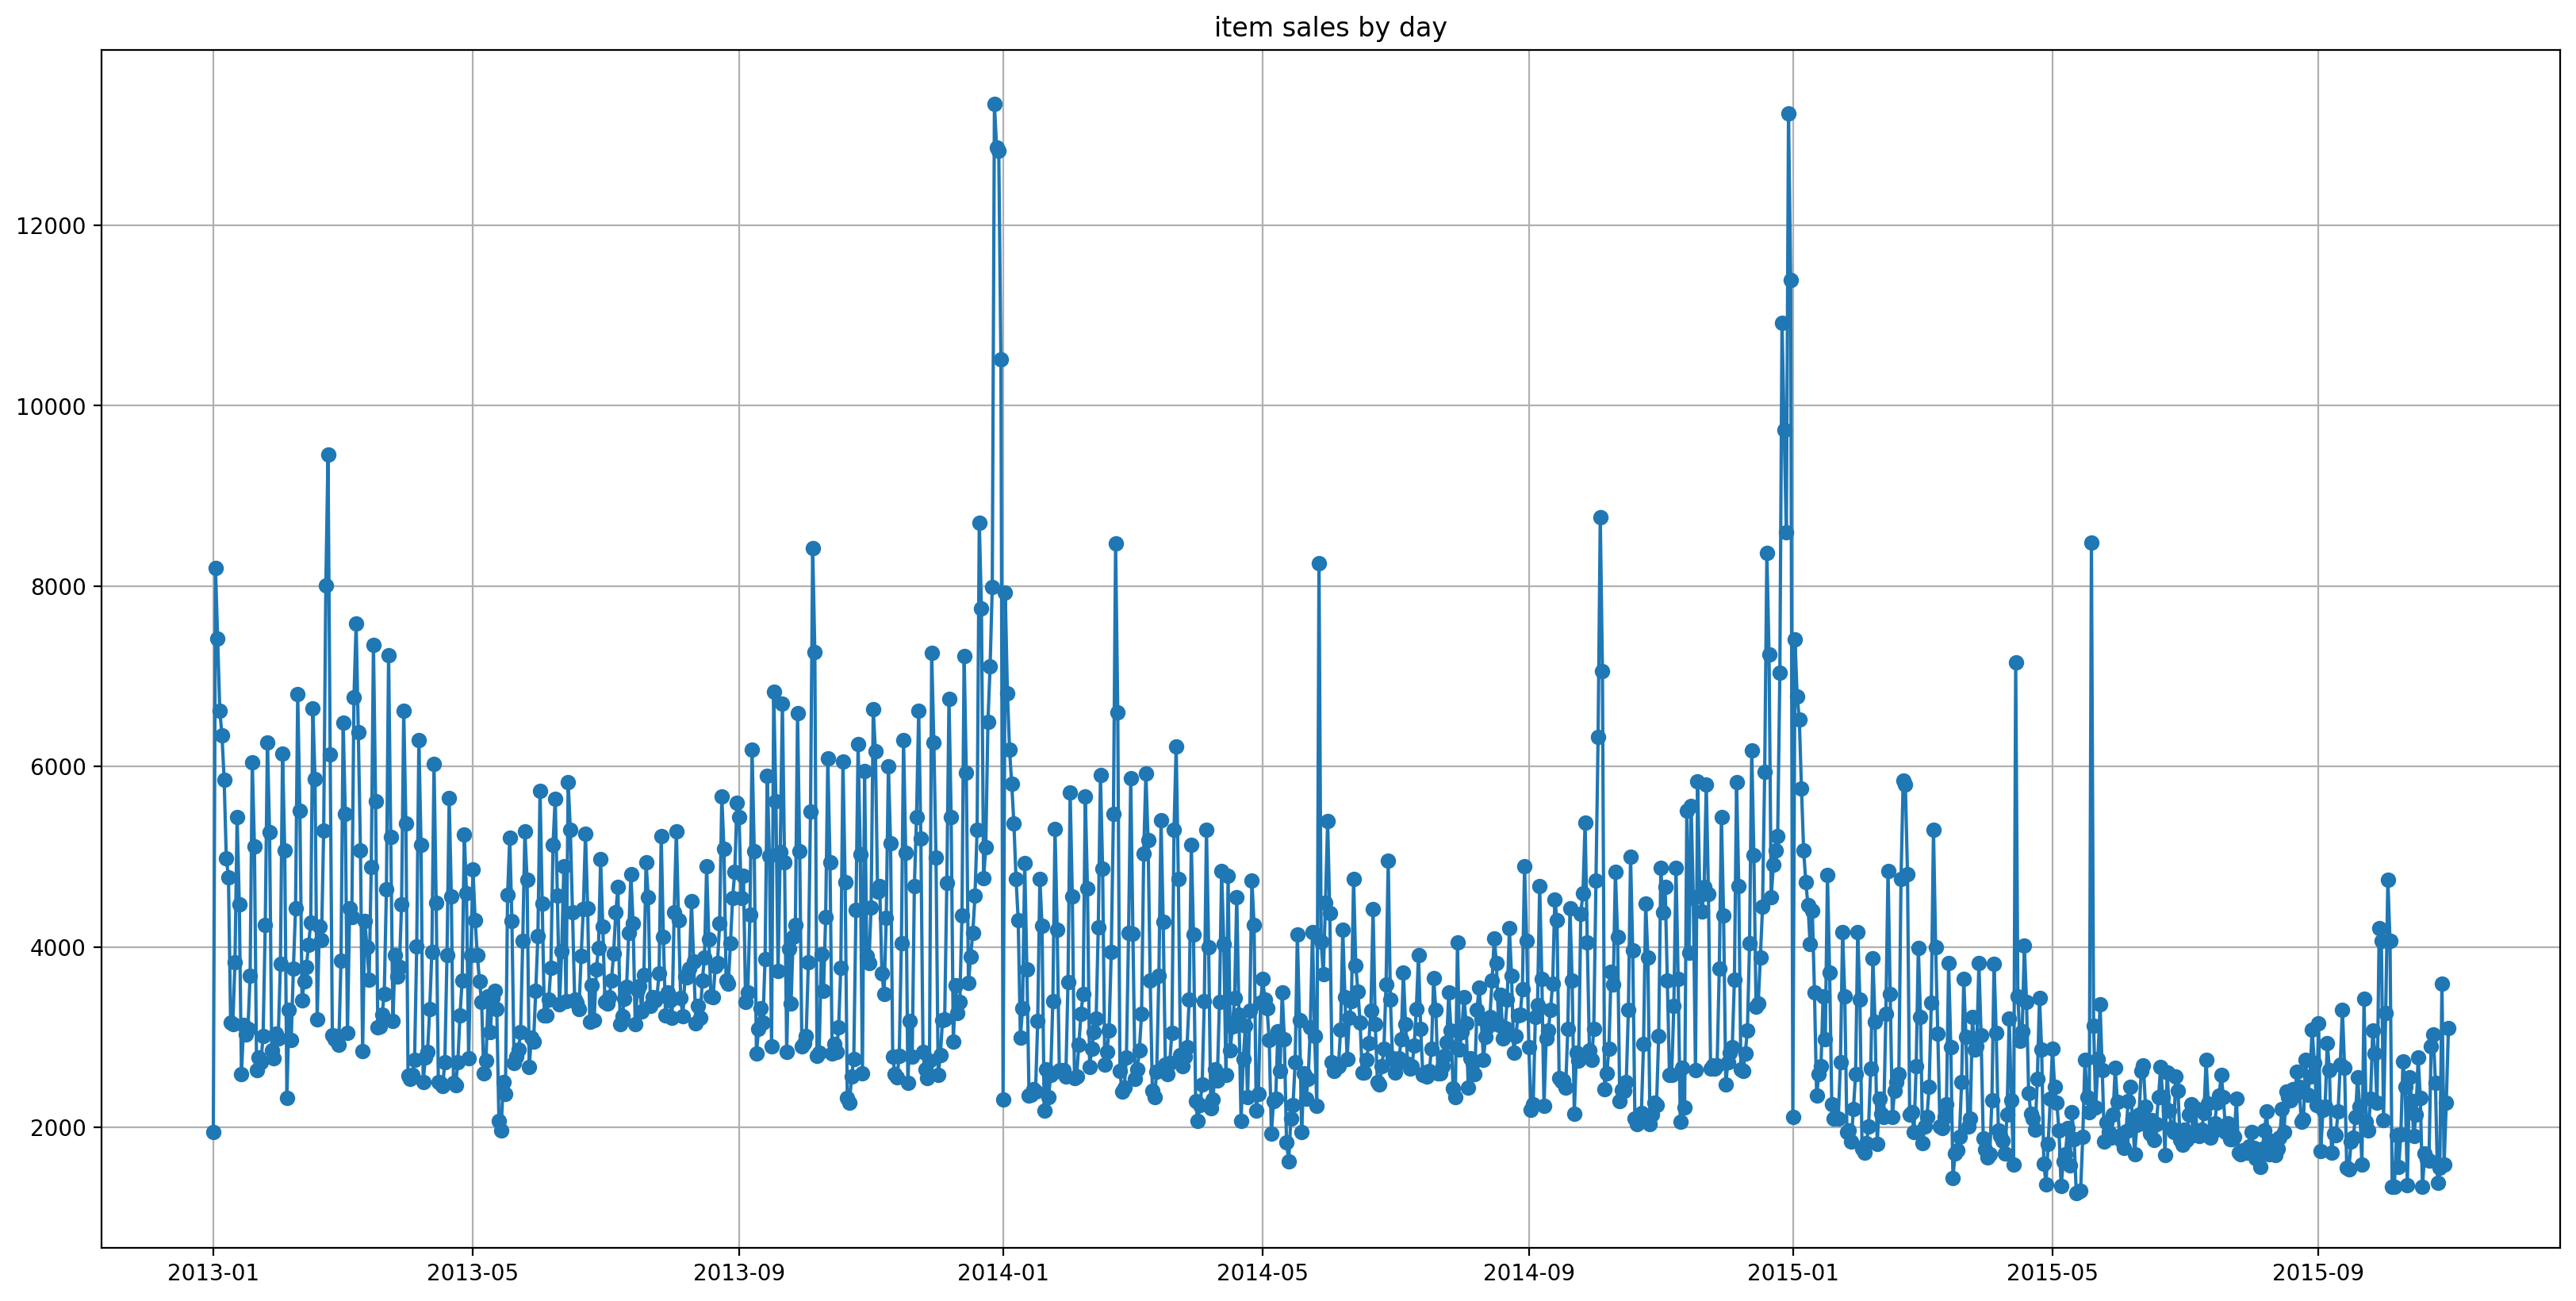

In [6]:
# visualization

series = df_train.groupby(df_train.date).item_cnt_day.sum()

pyplot.figure(figsize=(20,10), dpi=200)
pyplot.plot_date(date2num(series.index), series, linestyle='solid')
pyplot.title('item sales by day')
pyplot.grid()
pyplot.show()

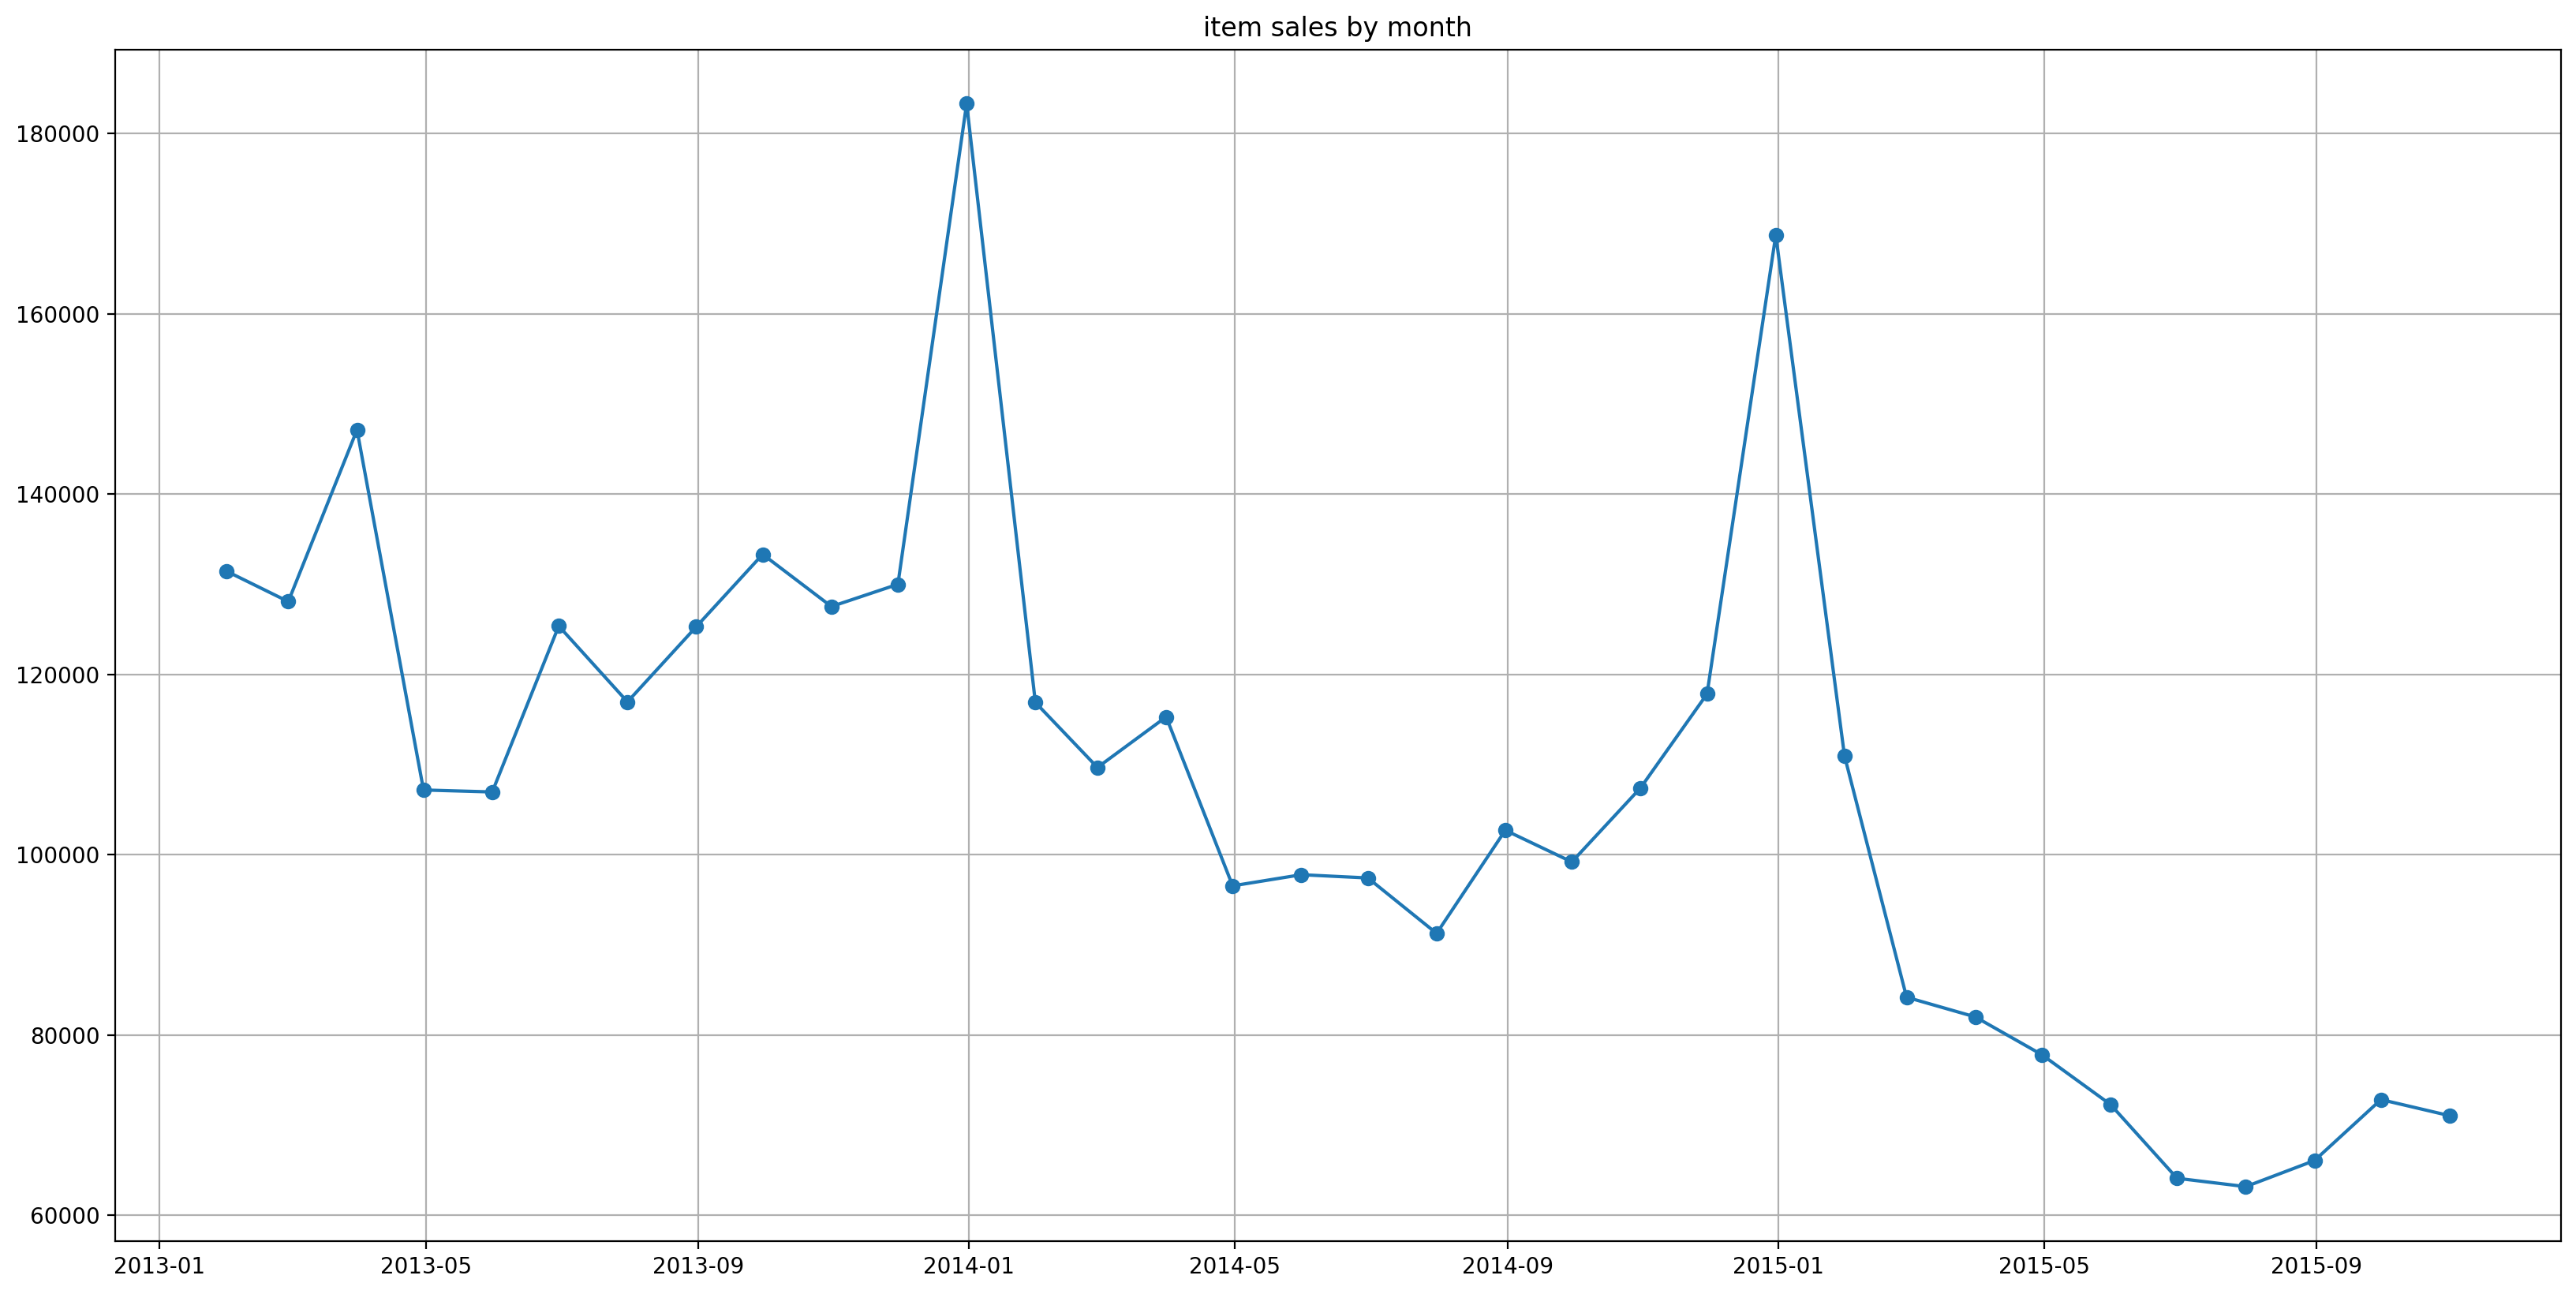

In [7]:
series = df_train.groupby(df_train.date).item_cnt_day.sum()
series.index = pandas.to_datetime(series.index)
series = series.groupby(pandas.Grouper(freq='M')).sum()

pyplot.figure(figsize=(20,10), dpi=200)
pyplot.plot_date(date2num(series.index), series, linestyle='solid')
pyplot.title('item sales by month')
pyplot.grid()
pyplot.show()

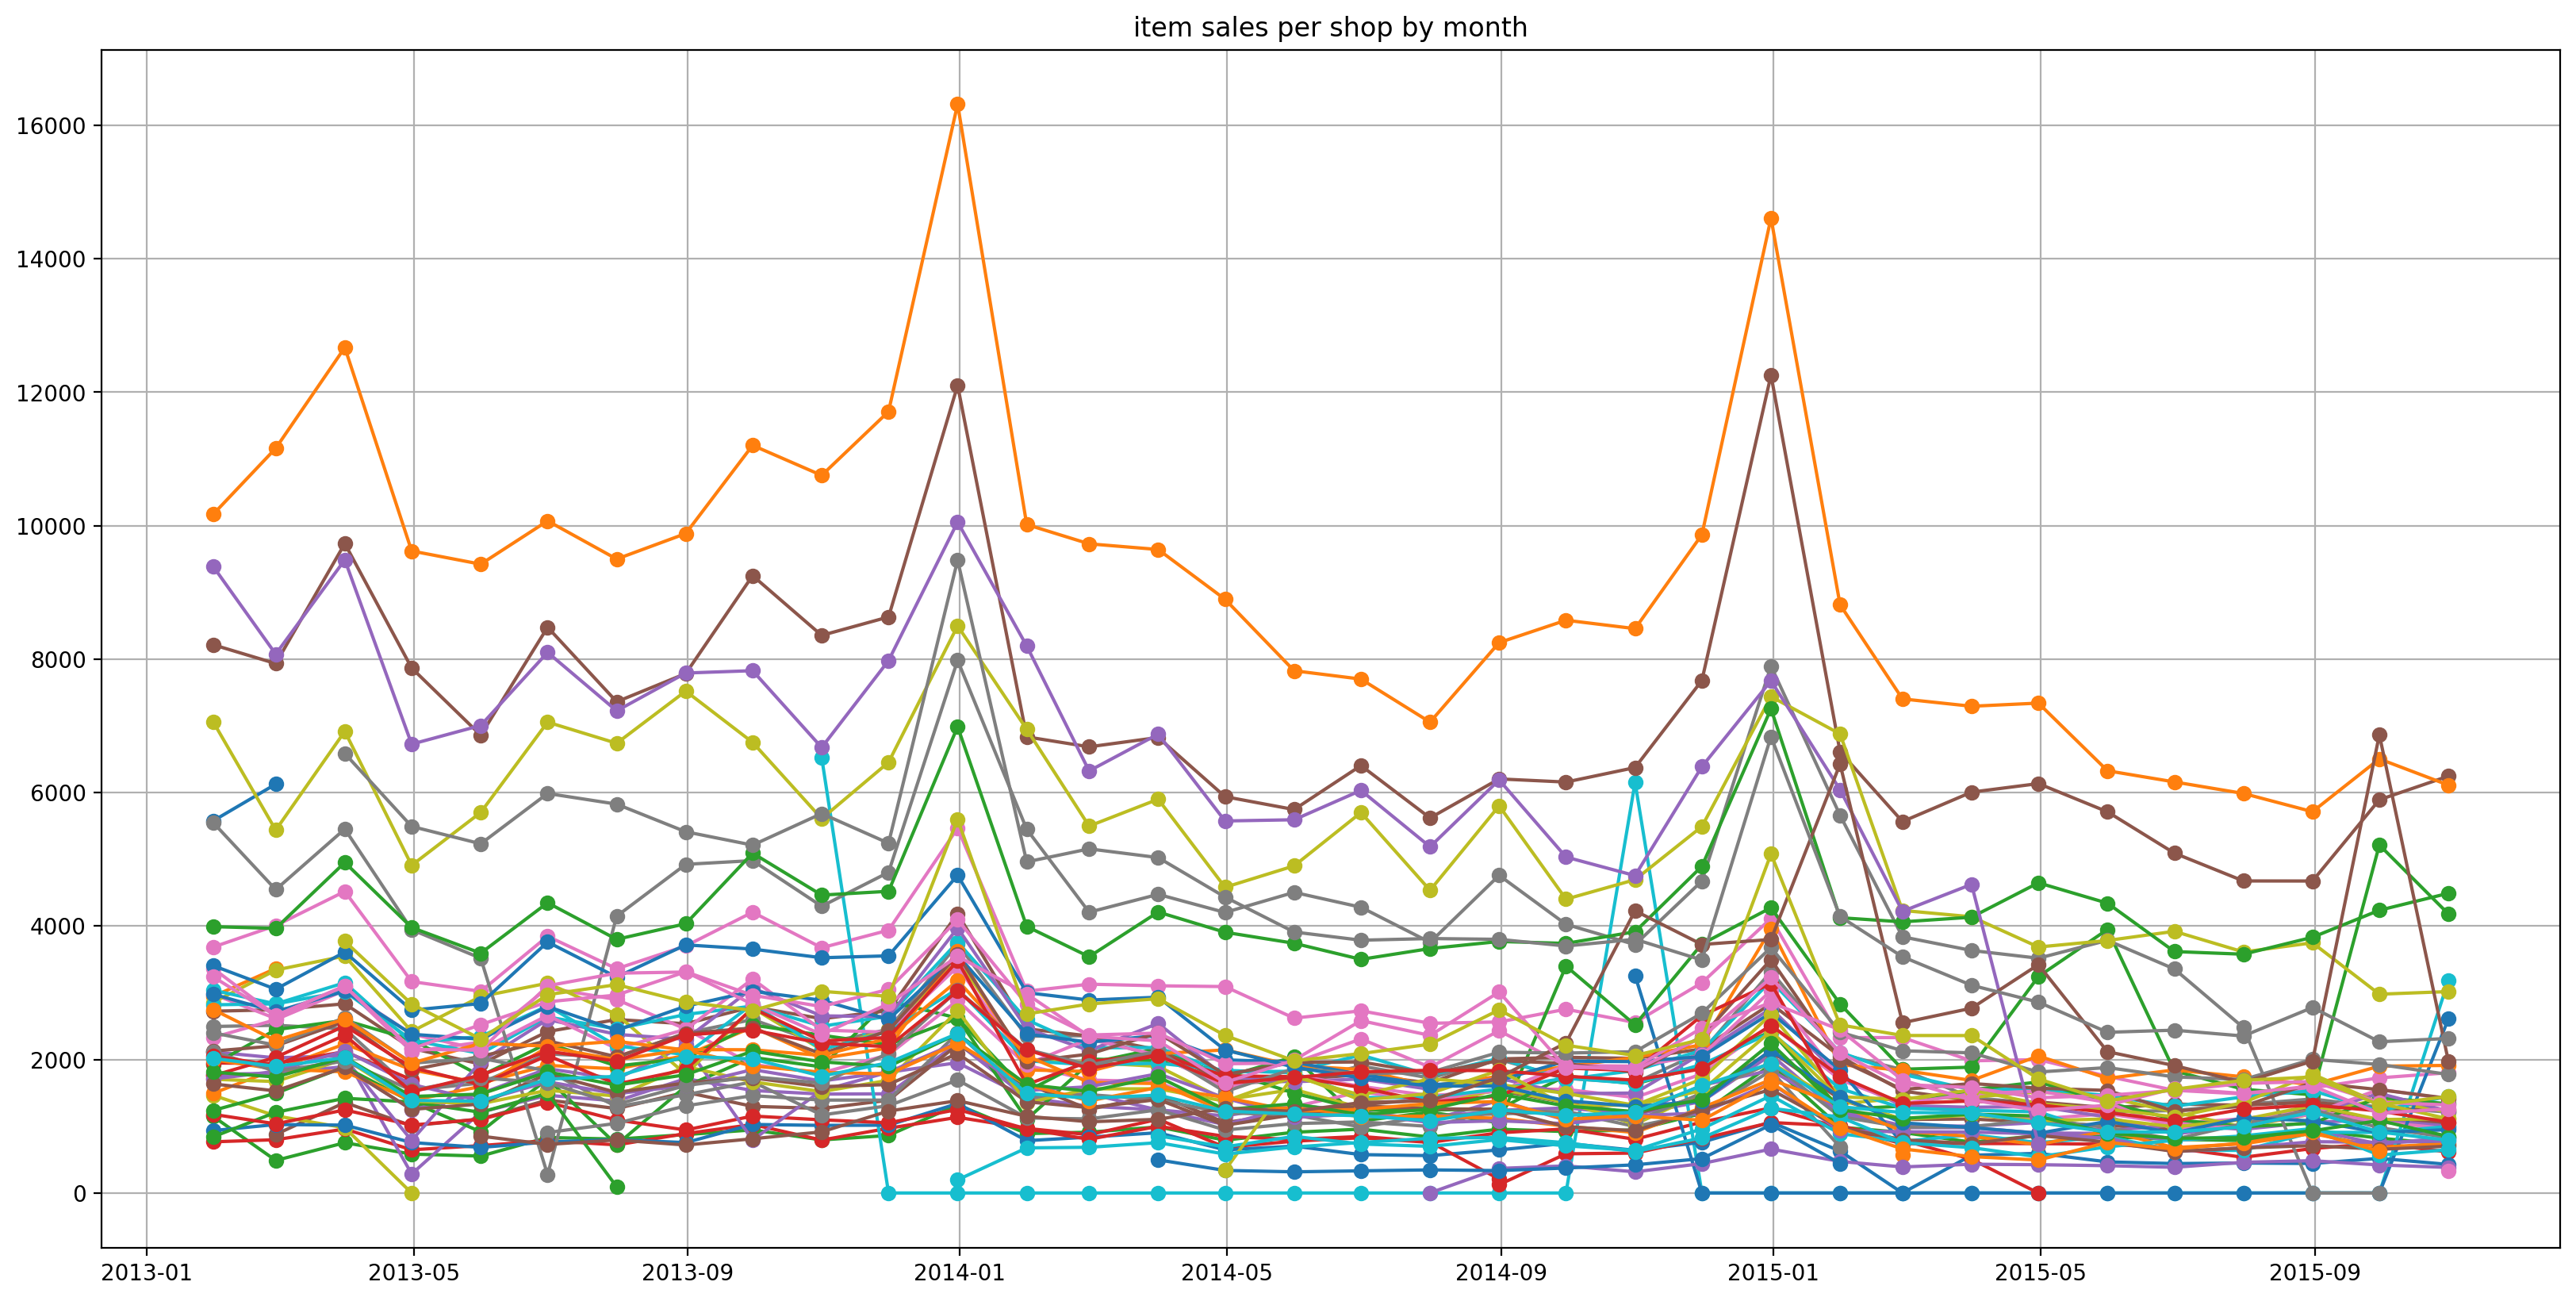

In [8]:
series = df_train.groupby([df_train.date,df_train.shop_id]).item_cnt_day.sum()

pyplot.figure(figsize=(20,10), dpi=200)
for shop in df_shops.shop_id:
    series_per_shop = series.xs(shop, level=1, drop_level=False)
    series_per_shop = series_per_shop.reset_index(level=1, drop=True)
    series_per_shop.index = pandas.to_datetime(series_per_shop.index)
    series_per_shop = series_per_shop.groupby(pandas.Grouper(freq='M')).sum()
    pyplot.plot_date(date2num(series_per_shop.index), series_per_shop, linestyle='solid')
pyplot.title('item sales per shop by month')
pyplot.grid()
pyplot.show()

# Baseline Model 1: Markov property on sales

This is a model based on the Markov process assumption: The probability distribution of the future states depends only on the present state, i.e.,

$$\mathbf{P}(X_{n+1}=x_n|\{X_i=x_i\}_{i=0}^n)=\mathbf{P}(X_{n+1}=x_{n+1}|X_n=x_n)$$

In the final prediction we also clip the value into the $[0,19]$ range, which result in the RMSE score of `1.16115` in the public leaderboard.

In [10]:
# baseline model 1: Markov property on sales

df_model_baseline1 = df_train[df_train.date_block_num == 33].groupby([df_train.shop_id,df_train.item_id]).item_cnt_day.sum().reset_index().rename(columns={'item_cnt_day':'item_cnt_month'})
df_prediction_baseline1 = df_test.merge(df_model_baseline1,on=['shop_id','item_id'],how='left')[['ID','item_cnt_month']].fillna(0).set_index('ID').clip(0,19)
df_prediction_baseline1.to_csv('../predictions/baseline1.csv')

# Baseline Model 2: Markov property on annual rate of change

In [ ]:
# Baseline Model 2

# TODO

# Model: XGBoost Regression

In [ ]:
# Category Mapper

def category_mapper(item_category_id):
    new_categories = [0,1,8,9,10,18,25,26,28,32,37,43,55,61,73,79,81,83,84]
    for i in range(len(new_categories)-1):
        if new_categories[i] <= item_category_id < new_categories[i+1]:
            return i

df_items.item_category_id = df_items.item_category_id.apply(category_mapper)